# House price predictions for the kaggle competition

In [6]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
from IPython.display import display
import math
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score,r2_score, log_loss, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import probplot as qqplot
from sklearn.svm.libsvm import predict_proba # need for the log_loss metric
import warnings

# Settings

In [3]:
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', 500)
plt.style.use('ggplot')
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None
print(plt.rcParams.get('figure.figsize'))
plt.rcParams['figure.figsize'] = (6, 4)
%matplotlib inline  
 

[6.4, 4.8]


# Definitions

In [4]:
def calc_rmse(sumofresids, n):#Equal name: rms-Deviation. RMSE=Variance(of y-hat) + Bias (of y-hat and y)

    rmse = math.sqrt(sumofresids/n)
    return rmse


def calc_avg_deviation(predictedSalesPrice,realSalesPrice):

    dferror = pd.DataFrame( data = predictedSalesPrice, columns=['PredictedSalesPrice'],\
                           copy = True)
    
    dferror['SalePrice']=realSalesPrice
    
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
  
    # square residues and sum em up
    avg_deviation = dferror.Residues.sum()/dferror.shape[0]
  
    return avg_deviation

    
def calc_max_deviation(predictedSalesPrice,realSalesPrice):

    # put all args into a dataframs
    # calc residues and avg bias
    dferror = pd.DataFrame( data = predictedSalesPrice, columns=['PredictedSalesPrice'],\
                           copy = True)
    
    dferror['SalePrice']=realSalesPrice
    
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
    
    dferror['Absolute_Residues']=dferror['Residues'].apply(lambda x: np.sqrt(x*x))
  
    # square residues and sum em up
    max_dev = dferror['Absolute_Residues'].max()
  
    return max_dev
    
    
def calc_r_sq_by_hand (predictedSalesPrice,realSalesPrice):

    dferror = pd.DataFrame( data = predictedSalesPrice, columns=['PredictedSalesPrice'], copy = True)
    dferror['SalePrice']=realSalesPrice
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
    dferror['Deviation_true_y_from_mean'] = dferror['SalePrice']-dferror['SalePrice'].mean()
    explained_variance = dferror.Residues.apply(lambda x: x*x).sum()
    total_variance = dferror.Deviation_true_y_from_mean.apply(lambda x: x*x).sum()
    r_squared = 1-explained_variance/total_variance
    return r_squared

def calc_adj_r_sq_by_hand (predictedSalesPrice,realSalesPrice, p):

    dferror = pd.DataFrame( data = predictedSalesPrice, columns=['PredictedSalesPrice'],\
                           copy = True)
    dferror['SalePrice']=realSalesPrice
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
    dferror['Deviation_true_y_from_mean'] = dferror['SalePrice']-dferror['SalePrice'].mean()
    explained_variance = dferror.Residues.apply(lambda x: x*x).sum()
    total_variance = dferror.Deviation_true_y_from_mean.apply(lambda x: x*x).sum()
    r_squared = 1-explained_variance/total_variance
    n = dferror.shape[0]
    adj_r_squared = 1-(1-r_squared)*((n-1)/(n-p-1))
    return adj_r_squared


def makeOutputFile(df,col, number):
    """
    Args:
    df (dataframe):
    col(str): name of the column width predicted values
    number (int): index of output file
    """
    df.to_csv('My_submission_'+str(number)+'.csv',index=True,columns=[col], index_label='Id')
    print("\n **************** Output written to: 'My_submission_{}.csv' \n".format(number))

    
def calc_rmse_by_hand(predictedSalesPrice,realSalesPrice,predictorObservations):

    dferror = pd.DataFrame( predictorObservations, copy = True)
    dferror['PredictedSalesPrice'] = predictedSalesPrice
    dferror['SalePrice']=realSalesPrice
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
    dferror['LogResidues']=(dferror.PredictedSalesPrice.apply(lambda x: np.log(x)))-\
                                    (dferror.SalePrice.apply(lambda x: np.log(x)))
    # square residues and sum em up
    squaredsumoferrors = dferror.Residues.apply(lambda x: x*x).sum()
    squaredsumoflogerrors = dferror.LogResidues.apply(lambda x: x*x).sum()
    
    return calc_rmse(squaredsumoferrors, dferror.shape[0])
    
def calc_logrmse_by_hand(predictedSalesPrice,realSalesPrice,predictorObservations):
  
    dferror = pd.DataFrame( predictorObservations, copy = True)
    dferror['PredictedSalesPrice'] = predictedSalesPrice
    dferror['SalePrice']=realSalesPrice
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
    dferror['LogResidues']=(dferror.PredictedSalesPrice.apply(lambda x: np.log(x)))-\
                                    (dferror.SalePrice.apply(lambda x: np.log(x)))
    # square residues and sum em up
    squaredsumoferrors = dferror.Residues.apply(lambda x: x*x).sum()
    squaredsumoflogerrors = dferror.LogResidues.apply(lambda x: x*x).sum()
    
    
    return calc_rmse(squaredsumoflogerrors, dferror.shape[0])

def calc_logrmse_by_hand2(realSalesPrice,predictedSalesPrice):

    dferror = pd.DataFrame(predictedSalesPrice, np.arange(predictedSalesPrice.shape[0]), ['PredictedSalesPrice'])
    #dferror['PredictedSalesPrice'] = predictedSalesPrice
    dferror['SalePrice']=pd.Series(realSalesPrice.tolist(), index = np.arange(predictedSalesPrice.shape[0] ))
    #print(dferror.head())
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
    dferror['LogResidues']=(dferror.PredictedSalesPrice.apply(lambda x: np.log(x)))-\
                                    (dferror.SalePrice.apply(lambda x: np.log(x)))
    # square residues and sum em up
    squaredsumoferrors = dferror.Residues.apply(lambda x: x*x).sum()/dferror.shape[0]
    squaredsumoflogerrors = np.sqrt(dferror.LogResidues.apply(lambda x: x*x).sum()/dferror.shape[0])
    
    return calc_rmse(squaredsumoflogerrors, dferror.shape[0])
    

def plot_residues(predictedSalesPrice,realSalesPrice,predictorObservations):

    dferror = pd.DataFrame( data = predictorObservations)
    dferror['PredictedSalesPrice'] = predictedSalesPrice
    dferror['SalePrice']=realSalesPrice
    dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
    dferror['LogResidues']=(dferror.PredictedSalesPrice.apply(lambda x: np.log(x)))-\
                                    (dferror.SalePrice.apply(lambda x: np.log(x)))
    # square residues and sum em up
    squaredsumoferrors = dferror.Residues.apply(lambda x: x*x).sum()
    squaredsumoflogerrors = dferror.LogResidues.apply(lambda x: x*x).sum()
    
    fig=plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.set_title('Residue plot')
    ax1.set_xlabel('Predicted SalePrice')
    ax1.set_ylabel('Residues')
    ax1.scatter(dferror.PredictedSalesPrice,dferror.Residues, color='red')
    ax2.scatter(dferror.PredictedSalesPrice,dferror.LogResidues, color='blue')
    ax2.set_title('Log residue plot')
    ax2.set_xlabel('Predicted SalePrice')
    ax2.set_ylabel('Log residues')
    plt.show()
    

def plot_residues_boxed(predictedSalesPrice,realSalesPrice,predictorObservations):

        dferror = pd.DataFrame( data = predictorObservations)
        dferror['PredictedSalesPrice'] = predictedSalesPrice
        dferror['SalePrice']=realSalesPrice
        dferror['Residues']=dferror.PredictedSalesPrice-dferror.SalePrice
        dferror['LogResidues']=(dferror.PredictedSalesPrice.apply(lambda x: np.log(x)))-\
                                        (dferror.SalePrice.apply(lambda x: np.log(x)))


        binz = [dferror['PredictedSalesPrice'].min() - 1,
        dferror['PredictedSalesPrice'].quantile(.1),
        dferror['PredictedSalesPrice'].quantile(.2),
        dferror['PredictedSalesPrice'].quantile(.3),
        dferror['PredictedSalesPrice'].quantile(.4),
        dferror['PredictedSalesPrice'].quantile(.5),
        dferror['PredictedSalesPrice'].quantile(.6),
        dferror['PredictedSalesPrice'].quantile(.7),
        dferror['PredictedSalesPrice'].quantile(.8),
        dferror['PredictedSalesPrice'].quantile(.9),
        dferror['PredictedSalesPrice'].max()
        ]

        dferror['Status'] = pd.cut(dferror['PredictedSalesPrice'], bins=binz)

        fig, (ax1,ax2) =plt.subplots(1,2,figsize=(15, 6))

        sns.boxplot(dferror['Status'],\
                    dferror['Residues'], ax=ax1)

        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
        ax1.set_ylim((-150000,150000))
        ax1.set_xlabel('Predicted SalePrice')
        ax1.set_title('Residue plot')


        sns.boxplot(dferror['Status'],\
                    dferror['LogResidues'], ax=ax2)

        ax2.set_xlabel('Predicted SalePrice')

        ax2.set_title('Log residue plot')

        plt.xticks(rotation=90)

        plt.ylim((-1.5,1.5))

        plt.show()
    
    
    
def plot_real_and_predicted_values(predictor,true_target,predicted_target, intercept, coef):
    
    predict_by_line_eq = lambda x: intercept + coef*x
    predicted_target_by_line_eq = predict_by_line_eq(predictor)
    
    fig=plt.figure()#figure object=container
    #create axes object. add_axes also creates this type oj object but with different positioning
    ax=fig.add_subplot(1,1,1)
    ax.set_title('Real and predicted values')
    ax.set_xlabel('Predictor')
    ax.set_ylabel('SalePrice')
    ax.scatter(predictor,true_target, color='black')
    ax.scatter(predictor, predicted_target, color='red')
    ax.scatter(predictor, predicted_target_by_line_eq, color='green', s = 5)
    plt.show()



# 1. Data exploration
Read data and merge train and test data from the competition.

In [5]:
# Import data
df_train = pd.read_csv('train.csv', sep=',', index_col=0)

df_test =  pd.read_csv('test.csv', sep=',', index_col=0)

# merge both data sets and drop SalePrice for inspection
df_train = pd.read_csv('train.csv', sep=',', index_col=0)

df_test =  pd.read_csv('test.csv', sep=',', index_col=0)

merged_data = pd.concat([df_train, df_test]).drop('SalePrice', axis = 1)

#df = merged_data.T 
#df
#df = df.isnull().sum().div(df.shape[0])
#df[df > 0.1]
#merged_data.loc[merged_data.index == 666]

print('Shapes of the dataframes:')

display(df_train.shape, df_test.shape, merged_data.shape)

Shapes of the dataframes:


(1460, 80)

(1459, 79)

(2919, 79)

Investigate data by type. Display unique values and nan values.

In [6]:
dtypes = ['int64','float64','object']

for datatype in dtypes:

    data_by_dtype = merged_data.select_dtypes([datatype])

    print('\n**** Number of unique values and nan-fraction of ' \
          'features of datatype {} ({} total)'.format(datatype, data_by_dtype.columns.shape[0]))

    for col in data_by_dtype.columns:

        number_of_unique_values = data_by_dtype[col].unique().shape[0]

        nan_fraction = data_by_dtype[col].isnull().sum() / data_by_dtype[col].shape[0]

        print('{:15}: {:5}, {:05.7f}'.format(col, number_of_unique_values, nan_fraction))



**** Number of unique values and nan-fraction of features of datatype int64 (25 total)
1stFlrSF       :  1083, 0.0000000
2ndFlrSF       :   635, 0.0000000
3SsnPorch      :    31, 0.0000000
BedroomAbvGr   :     8, 0.0000000
EnclosedPorch  :   183, 0.0000000
Fireplaces     :     5, 0.0000000
FullBath       :     5, 0.0000000
GrLivArea      :  1292, 0.0000000
HalfBath       :     3, 0.0000000
KitchenAbvGr   :     4, 0.0000000
LotArea        :  1951, 0.0000000
LowQualFinSF   :    36, 0.0000000
MSSubClass     :    16, 0.0000000
MiscVal        :    38, 0.0000000
MoSold         :    12, 0.0000000
OpenPorchSF    :   252, 0.0000000
OverallCond    :     9, 0.0000000
OverallQual    :    10, 0.0000000
PoolArea       :    14, 0.0000000
ScreenPorch    :   121, 0.0000000
TotRmsAbvGrd   :    14, 0.0000000
WoodDeckSF     :   379, 0.0000000
YearBuilt      :   118, 0.0000000
YearRemodAdd   :    61, 0.0000000
YrSold         :     5, 0.0000000

**** Number of unique values and nan-fraction of features of 

Quantify the absolute amounts of missing values for the features:

In [7]:
for datatype in dtypes:
    
    print("\n*** Nans in datatype " +datatype)
    
    series_of_nan_counts = merged_data.select_dtypes([datatype]).isnull().sum()
    
    ordered_nan_counts = series_of_nan_counts[series_of_nan_counts>0].sort_values()
    
    number_of_cols_no_nan = series_of_nan_counts[series_of_nan_counts == 0].shape[0]
    
    print("Number of features with no missing Values:"
          " {}\n{}".format(number_of_cols_no_nan, ordered_nan_counts))


*** Nans in datatype int64
Number of features with no missing Values: 25
Series([], dtype: int64)

*** Nans in datatype float64
Number of features with no missing Values: 0
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
GarageArea        1
GarageCars        1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
MasVnrArea       23
GarageYrBlt     159
LotFrontage     486
dtype: int64

*** Nans in datatype object
Number of features with no missing Values: 20
KitchenQual        1
SaleType           1
Exterior2nd        1
Exterior1st        1
Electrical         1
Functional         2
Utilities          2
MSZoning           4
MasVnrType        24
BsmtFinType1      79
BsmtFinType2      80
BsmtQual          81
BsmtExposure      82
BsmtCond          82
GarageType       157
GarageCond       159
GarageFinish     159
GarageQual       159
FireplaceQu     1420
Fence           2348
Alley           2721
MiscFeature     2814
PoolQC          2909
dtype: int64


The analysis reveals a hint for the necessary data preperation steps, such as:

Replacement of features, imputation of missing values, changing variable types and assignment of proper variable types.

For this, the data description seems helpful. However, lets look at the distributions of data first:

We display the distributions and the nan-fraction and total-nan amounts.

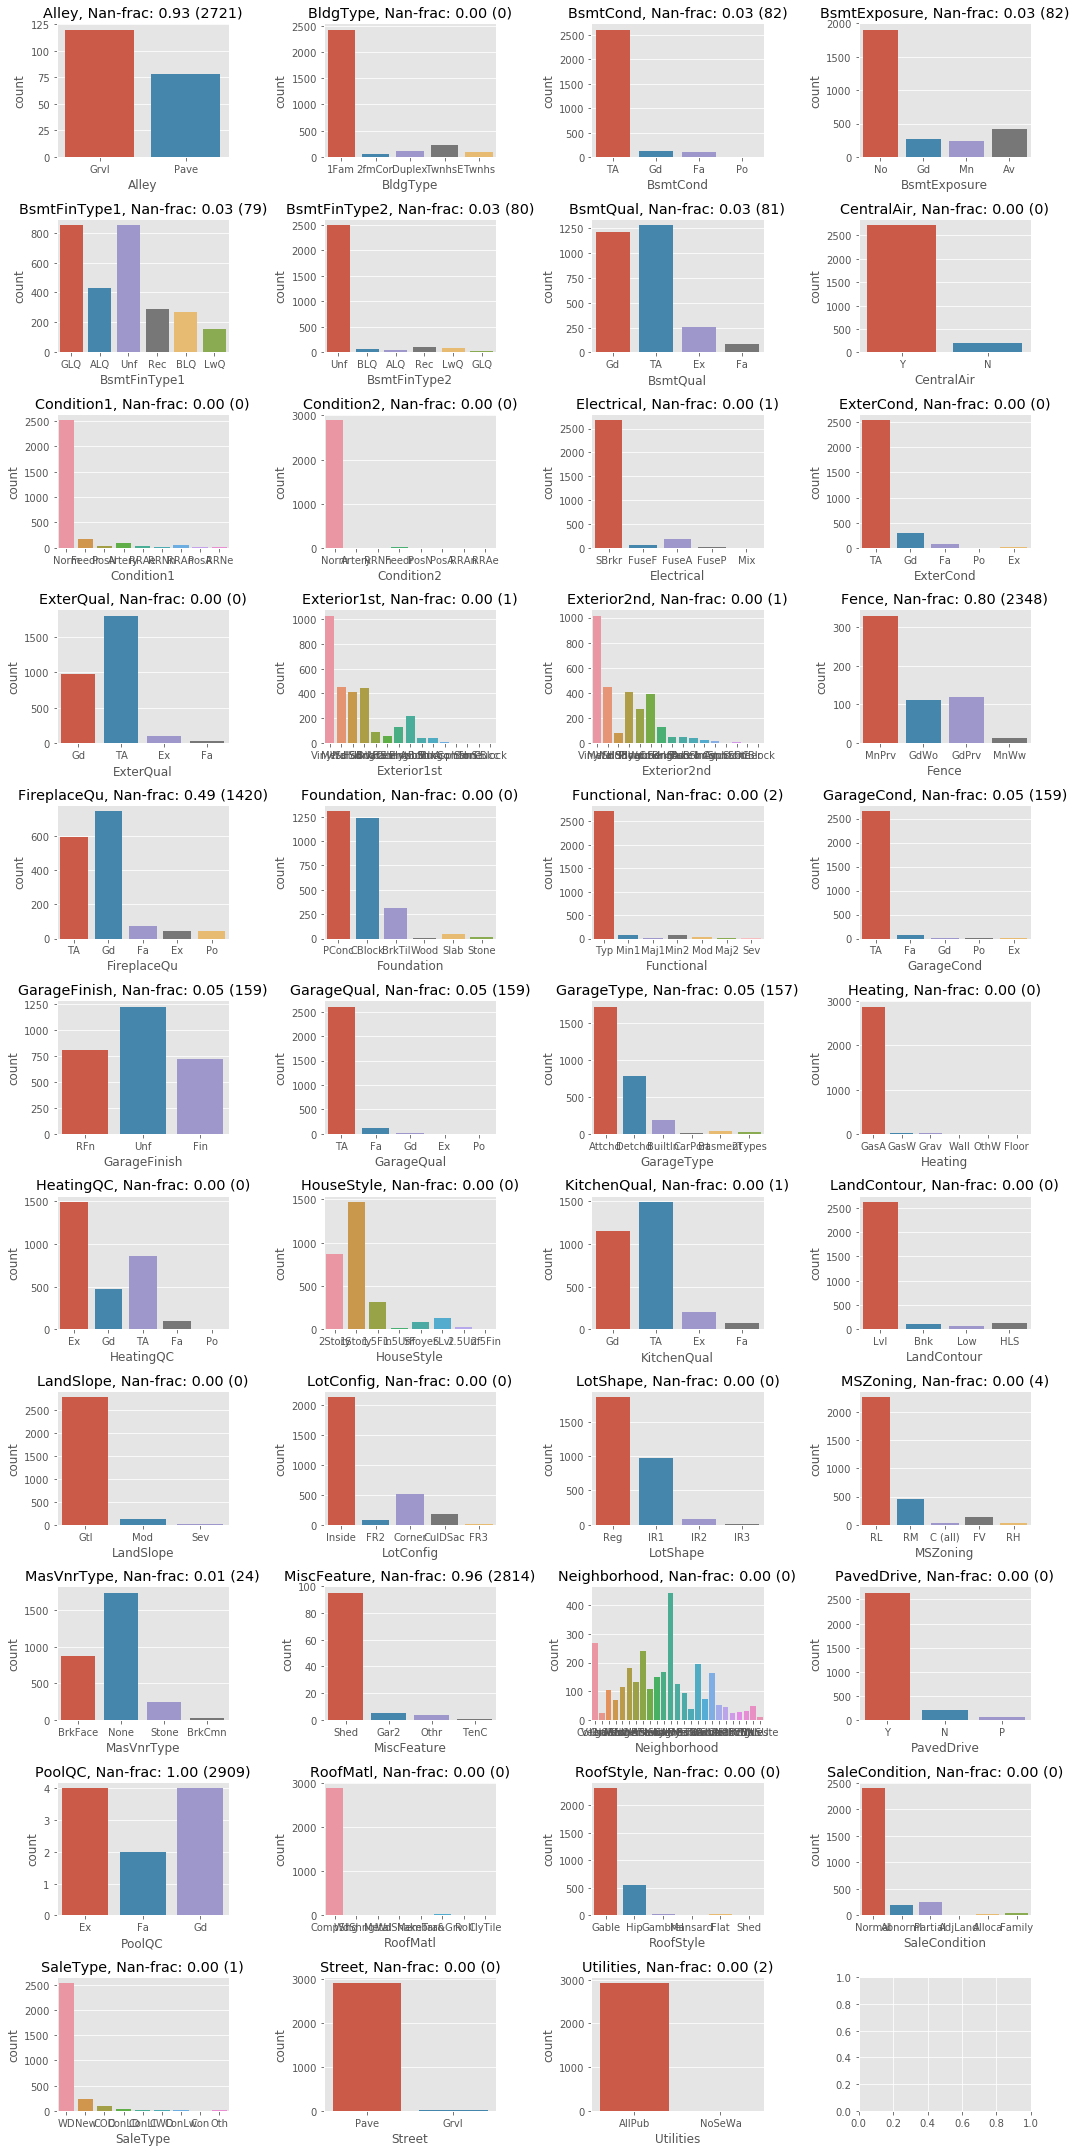

In [8]:
# re-add SalePrice
merged_data = pd.concat([df_train, df_test]).copy()

# list variable types
categorical_feature_list = merged_data.select_dtypes(['object']).columns

numerical_feature_list = merged_data.select_dtypes(['int64','float64']).columns

# Calc integer that represents the number of rows needed for X*4 subplots
# if X is the number of features
def func(x):
    
    while (x/4).is_integer() == False: x += 1
        
    return int(x/4)


next_multiple_of_4 = func(merged_data[categorical_feature_list].shape[1])

fig, axes = plt.subplots(next_multiple_of_4,4, figsize=(15,30))

for i, feature in enumerate(categorical_feature_list):
    
    sns.countplot(x=feature, data=merged_data, ax=axes[i // 4][i % 4 ] )
   
    total_nan_for_feature = merged_data[feature].isnull().sum()                                
    
    nan_frac_for_feature = merged_data[feature].isnull().sum() / merged_data[feature].shape[0]
   
    axes[i // 4][i % 4 ].set_title("{}, Nan-frac: {:0.2f} ({})".format(feature, nan_frac_for_feature, \
                                                                       total_nan_for_feature))
    
    
plt.tight_layout()    

plt.show()

In [9]:

merged_data.describe(include = ['O']).shape[1]

43

Index(['Blueste', 'NPkVill', 'BrDale', 'MeadowV', 'Veenker', 'Blmngtn',
       'SWISU', 'IDOTRR', 'ClearCr', 'BrkSide', 'Mitchel', 'StoneBr', 'Timber',
       'Sawyer', 'Crawfor', 'SawyerW', 'Edwards', 'NoRidge', 'NWAmes',
       'OldTown', 'Gilbert', 'Somerst', 'NridgHt', 'CollgCr', 'NAmes'],
      dtype='object', name='Neighborhood')

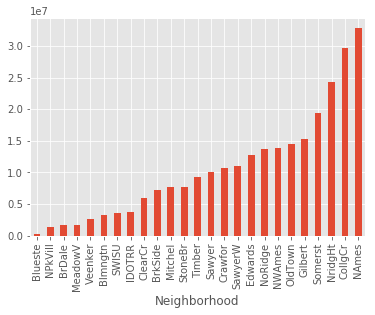

In [10]:
dummy = merged_data.groupby('Neighborhood')

type(dummy)

dummy.sum().sort_values(by = 'SalePrice').SalePrice.plot(kind = 'bar')

dummy.sum().sort_values(by = 'SalePrice').index

Index(['1.5Unf', '2.5Unf', '2.5Fin', 'SFoyer', 'SLvl', '1.5Fin', '2Story',
       '1Story'],
      dtype='object', name='HouseStyle')

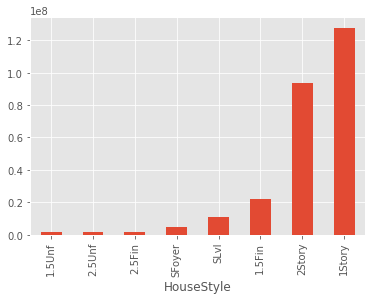

In [11]:
dummy = merged_data.groupby('HouseStyle')

type(dummy)

dummy.sum().sort_values(by = 'SalePrice').SalePrice.plot(kind = 'bar')

dummy.sum().sort_values(by = 'SalePrice').index

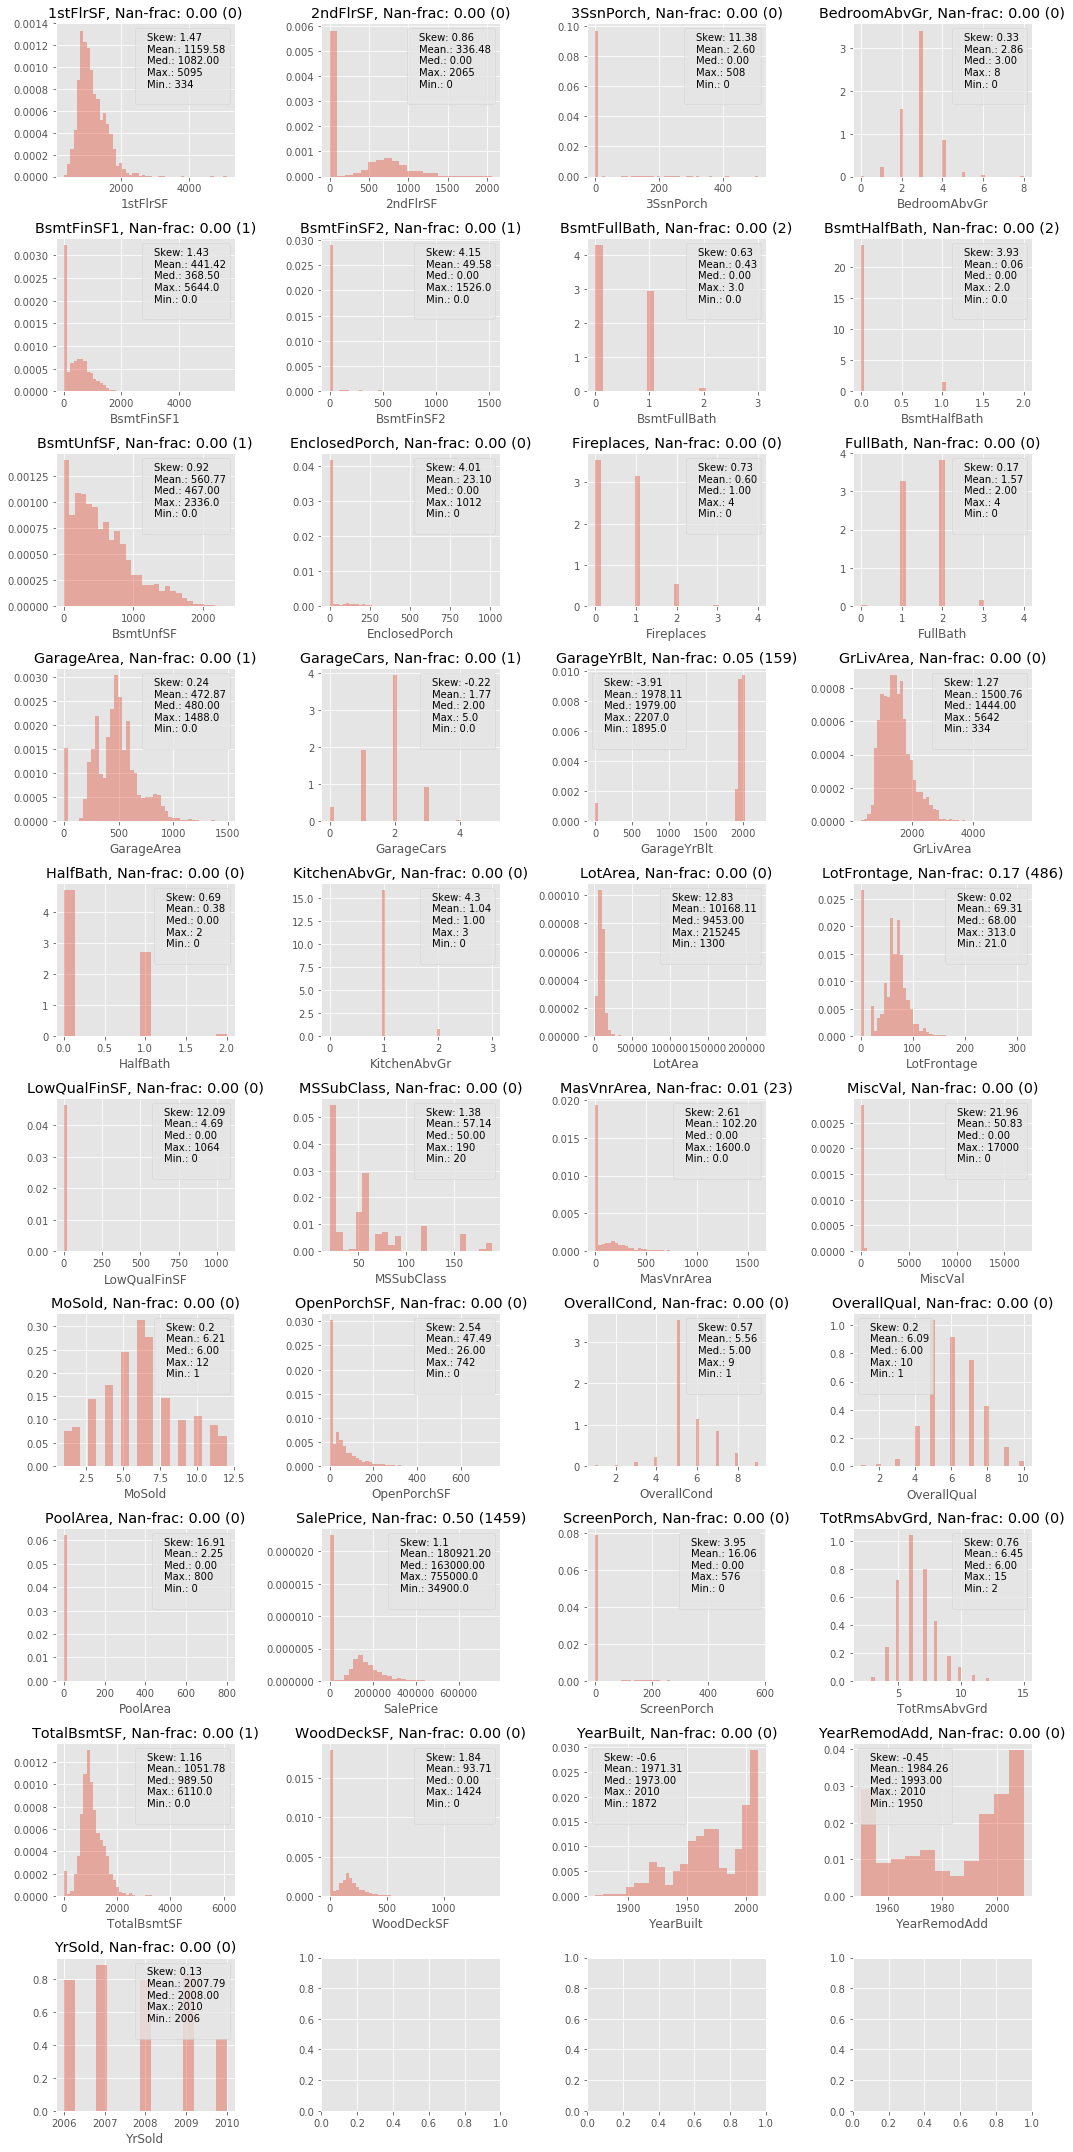

In [12]:
categorical_feature_list = merged_data.select_dtypes(['object']).columns

numerical_feature_list = merged_data.select_dtypes(['int64','float64']).columns


next_multiple_of_4 = func(merged_data[numerical_feature_list].shape[1])

fig, axes = plt.subplots(next_multiple_of_4,4, figsize=(15,30))

for i, feature in enumerate(numerical_feature_list):
    
    min_value = merged_data[feature].min()
    
    max_value = merged_data[feature].max()
    
    mean = merged_data[feature].mean()
    
    median = merged_data[feature].median()
    
    skew = round(merged_data[feature].fillna(0).skew(),2)
  
    sns.distplot(merged_data[feature].fillna(0), ax=axes[i // 4][i % 4 ], kde=False, norm_hist=True, \
                label='Skew: {}\n'
                      'Mean.: {:0.2f}\n'
                      'Med.: {:0.2f}\n'
                      'Max.: {}\n'
                      'Min.: {}\n'.format(skew, mean, median, max_value, min_value))
    
    
    total_nan_for_feature = merged_data[feature].isnull().sum()                                
    
    nan_frac_for_feature = merged_data[feature].isnull().sum() / merged_data[feature].shape[0]
   
    axes[i // 4][i % 4 ].set_title("{}, Nan-frac: {:0.2f} ({})".format(feature, nan_frac_for_feature, \
                                                                      total_nan_for_feature))
    
    axes[i // 4][i % 4 ].legend(handlelength=0)# hide the handle
    
plt.tight_layout()  

plt.show()

Now we perfom the first simple data preparation:

# 1.2 The target variable

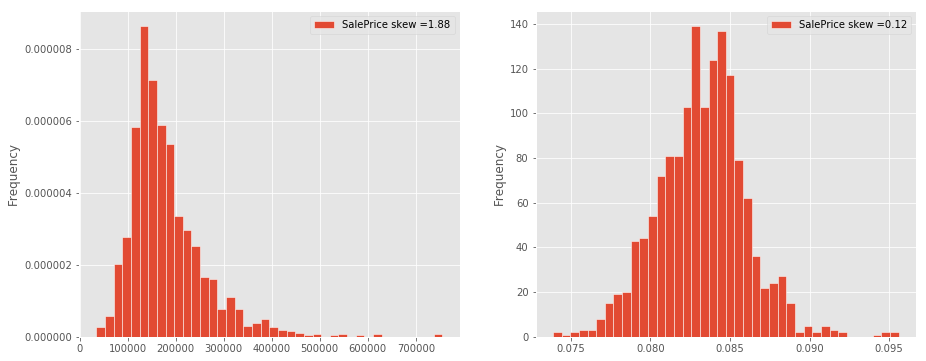

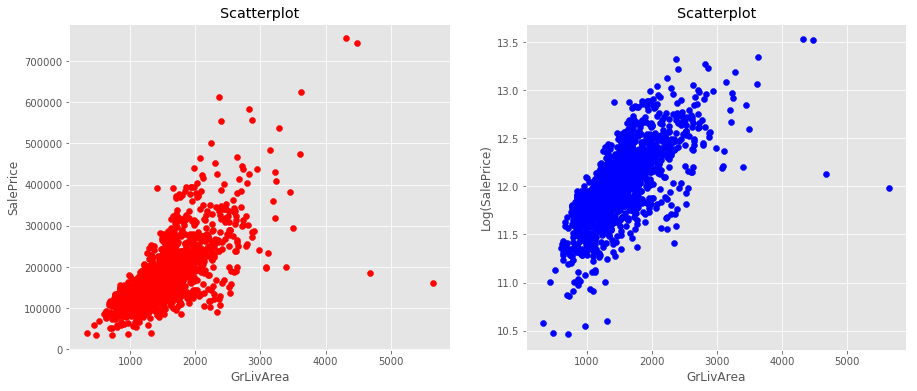

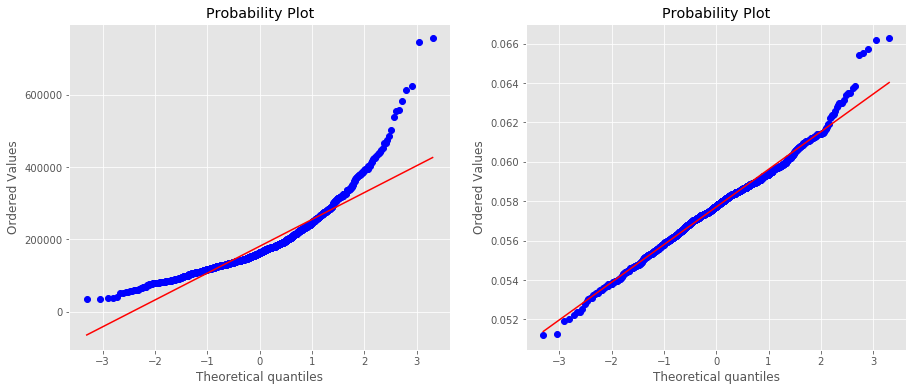

In [13]:
"""
Quantil:
    Wir geben einen Anteil p vor, und fragen bei welcher Merkmalsausprägung X = x die kum. Häufigkeit
    diesen Anteil erreicht. Sprich "das null komma zwei fünf quantil" ( p = 0.25= F(X = x_p)).
    Bei geordneten Datensätzen der größe n sind die Beobachtungswerte x_i genau die  "p_i = i/n"-Quantile
    (i = geordnete Nummerierung der Beobachtungen)
    
QQ-plot:
    Zum Vergleich zweier empirischer Verteilungen oder einer emp. mit einer theor. Warum geht bei Vgl. mit norm. Vert.
    die X-Achse von ~ -2-3 bis ~ 2-3 ? Weil die p-Quantile der empirischen Daten (z.B. 0.25-Quantil) der std. norm. Vert.
    eben bei diesen Werten liet.

Skewness:
    3rd-moment of "X standardized by sigma" E[(X-mu/sigma)^2]. > means right-skewness

"""
fig = plt.figure(figsize=(15, 6))

skewness = df_train['SalePrice'].skew()

skewness_log = df_train['SalePrice'].apply(lambda x:  np.log(x)).skew()

ax1 = fig.add_subplot(121)

ax2 = fig.add_subplot(122)

df_train['SalePrice'].plot.hist(edgecolor='white', bins=40, 
                                legend = True, label='SalePrice skew =' + str(round(skewness,2)), ax = ax1, normed = True)

df_train['SalePrice'].apply(lambda x:  1/np.log(x)).plot.hist(edgecolor='white', bins=40, 
                                legend = True, label='SalePrice skew =' +\
                                    str(round(skewness_log,2)), ax = ax2)
plt.show()


fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)

ax2 = fig.add_subplot(122)

ax1.scatter(df_train.GrLivArea,df_train.SalePrice, color='red')

ax2.scatter(df_train.GrLivArea,df_train.SalePrice.apply(lambda x:  np.log(x)), color='blue')

ax1.set_title('Scatterplot')

ax1.set_ylabel('SalePrice')

ax1.set_xlabel('GrLivArea')

ax2.set_title('Scatterplot')

ax2.set_ylabel('Log(SalePrice)')

ax2.set_xlabel('GrLivArea')

plt.show()



fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121)

ax1.set_title('QQ plot')
   
ax1.set_xlabel('Real SalePrice quantiles')

ax1.set_ylabel('Theor. quantiles')

theoretical_quantiles = qqplot(df_train['SalePrice'], plot = plt, dist = 'norm')

ax2 = fig.add_subplot(122)

ax2.set_title('QQ plot')
   
ax2.set_xlabel('Real log(SalePrice) quantiles')

ax2.set_ylabel('Theor. quantiles')

theoretical_quantiles = qqplot(df_train['SalePrice'].apply(lambda x:  1/np.log2(x)),\
                               plot = plt,dist = 'norm')
plt.show()



# 1.3 Relationships between variables

In [14]:
df_train_copy = df_train.copy()

df_train_copy['LogSalePrice'] = df_train['SalePrice'].apply(lambda x:  np.log(x))

correlDataFrame=df_train_copy.corr(method='pearson')# altern. try spearman (rank. corr.coeff.)

print(correlDataFrame[['LogSalePrice','SalePrice']].sort_values(by = 'SalePrice', ascending=False))

               LogSalePrice  SalePrice
SalePrice           0.94837    1.00000
LogSalePrice        1.00000    0.94837
OverallQual         0.81718    0.79098
GrLivArea           0.70093    0.70862
GarageCars          0.68062    0.64041
GarageArea          0.65089    0.62343
TotalBsmtSF         0.61213    0.61358
1stFlrSF            0.59698    0.60585
FullBath            0.59477    0.56066
TotRmsAbvGrd        0.53442    0.53372
YearBuilt           0.58657    0.52290
YearRemodAdd        0.56561    0.50710
GarageYrBlt         0.54107    0.48636
MasVnrArea          0.43081    0.47749
Fireplaces          0.48945    0.46693
BsmtFinSF1          0.37202    0.38642
LotFrontage         0.35588    0.35180
WoodDeckSF          0.33414    0.32441
2ndFlrSF            0.31930    0.31933
OpenPorchSF         0.32105    0.31586
HalfBath            0.31398    0.28411
LotArea             0.25732    0.26384
BsmtFullBath        0.23622    0.22712
BsmtUnfSF           0.22199    0.21448
BedroomAbvGr        0.209

# 1.4 Heatmap plots

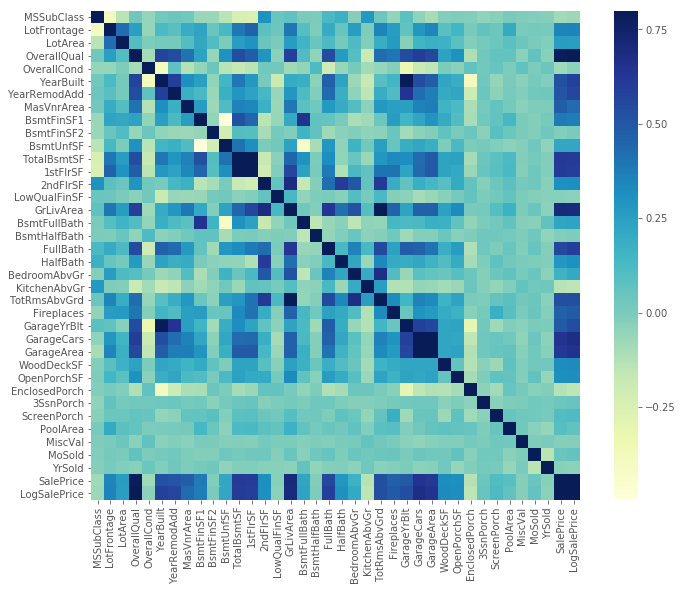

In [15]:
f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(correlDataFrame, vmax=.8, square=True, cmap="YlGnBu")

plt.show()

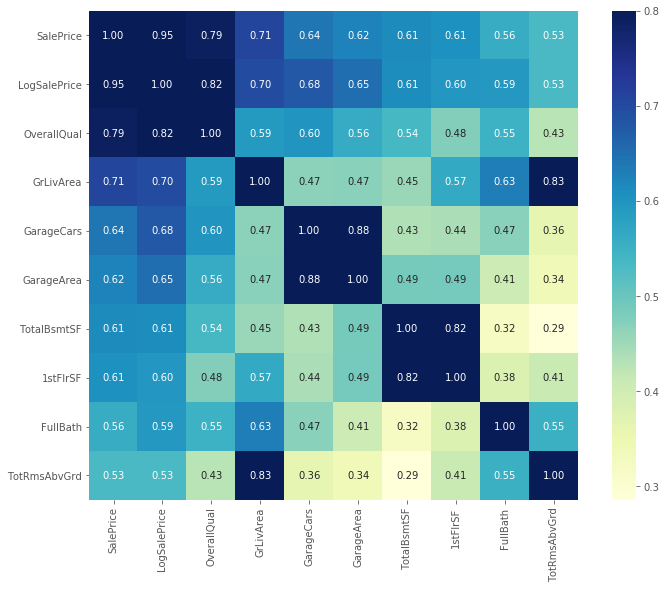

In [16]:
#list(correlDataFrame.SalePrice.sort_values(ascending=False))[]
mostCorrelFeatures = list(correlDataFrame.sort_values('SalePrice', ascending = False).index)[:10]

correlDataFrameWithHighCorrel = correlDataFrame.loc[mostCorrelFeatures][mostCorrelFeatures]

f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(correlDataFrameWithHighCorrel, vmax = .8, square = True,fmt='.2f', annot = True, cmap = "YlGnBu")

plt.show()
#annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values

# 1.5 Visualization of the dependencies of SalePrice on some selected Variables

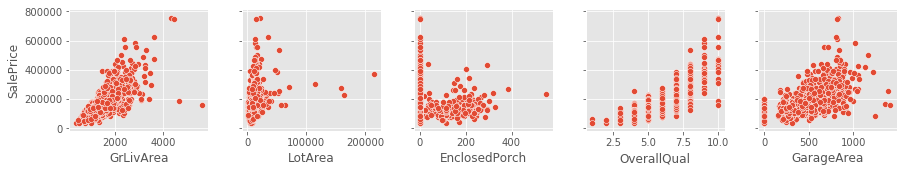

In [17]:
feature_list=['GrLivArea','LotArea','EnclosedPorch','OverallQual','GarageArea']#Variables for the 3 pair plots

pp = sns.pairplot(data=df_train, #sns pairplots
                  y_vars=['SalePrice'],
                  x_vars=feature_list)
plt.show()

In [117]:
features = merged_data.columns

list(merged_data.groupby(feature).mean().SalePrice.sort_values().index)

TypeError: 'Index' object is not callable

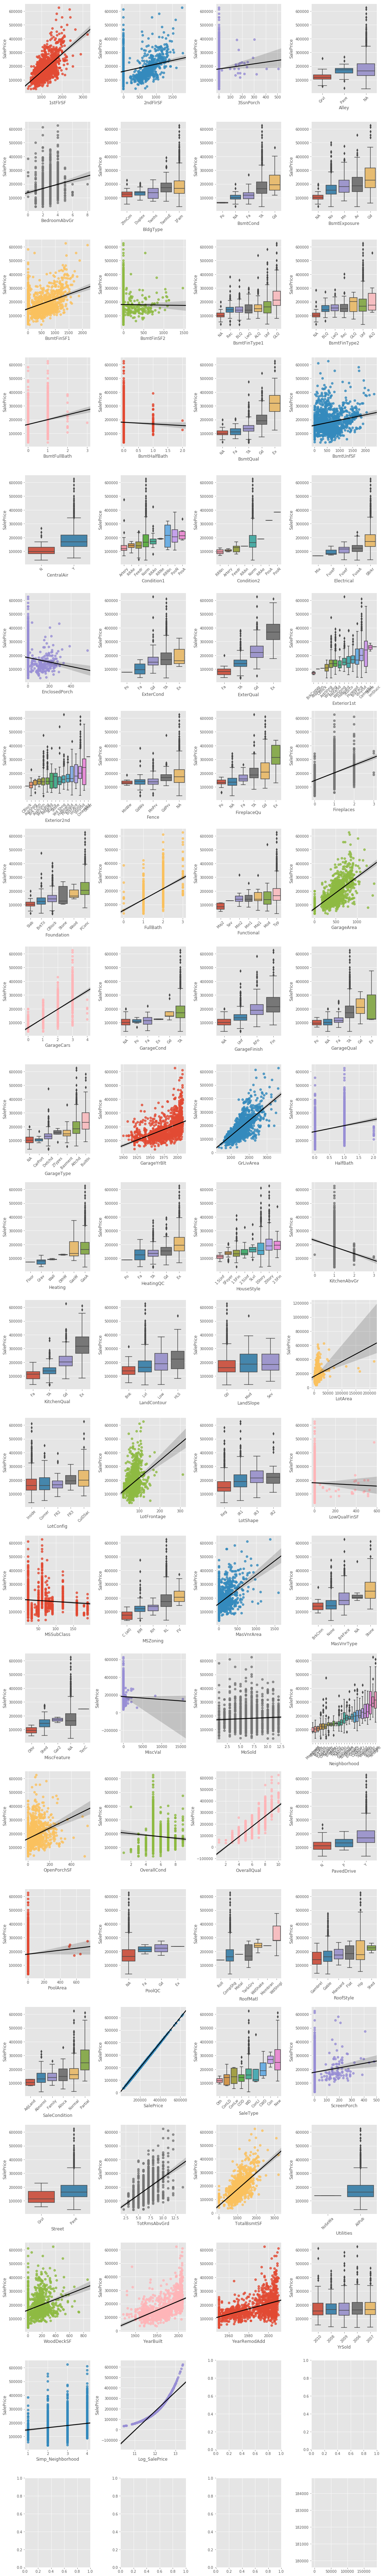

'\ncategorical_feature_list = merged_data.select_dtypes([\'object\']).columns\n\nnumerical_feature_list = merged_data.select_dtypes([\'int64\',\'float64\']).columns\n\n\nnext_multiple_of_4 = func(merged_data[numerical_feature_list].shape[1])\n\nfig, axes = plt.subplots(next_multiple_of_4,4, figsize=(15,30))\n\nfor i, feature in enumerate(numerical_feature_list):\n    \n    min_value = merged_data[feature].min()\n    \n    max_value = merged_data[feature].max()\n    \n    mean = merged_data[feature].mean()\n    \n    median = merged_data[feature].median()\n    \n    skew = round(merged_data[feature].fillna(0).skew(),2)\n  \n    sns.distplot(merged_data[feature].fillna(0), ax=axes[i // 4][i % 4 ], kde=False, norm_hist=True,                 label=\'Skew: {}\n\'\n                      \'Mean.: {:0.2f}\n\'\n                      \'Med.: {:0.2f}\n\'\n                      \'Max.: {}\n\'\n                      \'Min.: {}\n\'.format(skew, mean, median, max_value, min_value))\n    \n    \n    t

In [132]:
features = merged_data.columns

f, a = plt.subplots(22,4, figsize=(15,100))

for i, feature in enumerate(features):

    if merged_data[feature].dtype == object:

        ordered_label_list = merged_data.groupby(feature).mean().SalePrice.sort_values().index

        sns.boxplot(x=feature, y='SalePrice', data=merged_data, order= ordered_label_list,\
                    ax=a[i // 4][i % 4])
        
        a[i // 4][i % 4].set_xticklabels(ordered_label_list, rotation = 45)

    else:

        sns.regplot(feature, 'SalePrice', data=merged_data, line_kws={'color': 'black'}, ax=a[i // 4][i % 4])
        
plt.tight_layout()

plt.show()


"""
categorical_feature_list = merged_data.select_dtypes(['object']).columns

numerical_feature_list = merged_data.select_dtypes(['int64','float64']).columns


next_multiple_of_4 = func(merged_data[numerical_feature_list].shape[1])

fig, axes = plt.subplots(next_multiple_of_4,4, figsize=(15,30))

for i, feature in enumerate(numerical_feature_list):
    
    min_value = merged_data[feature].min()
    
    max_value = merged_data[feature].max()
    
    mean = merged_data[feature].mean()
    
    median = merged_data[feature].median()
    
    skew = round(merged_data[feature].fillna(0).skew(),2)
  
    sns.distplot(merged_data[feature].fillna(0), ax=axes[i // 4][i % 4 ], kde=False, norm_hist=True, \
                label='Skew: {}\n'
                      'Mean.: {:0.2f}\n'
                      'Med.: {:0.2f}\n'
                      'Max.: {}\n'
                      'Min.: {}\n'.format(skew, mean, median, max_value, min_value))
    
    
    total_nan_for_feature = merged_data[feature].isnull().sum()                                
    
    nan_frac_for_feature = merged_data[feature].isnull().sum() / merged_data[feature].shape[0]
   
    axes[i // 4][i % 4 ].set_title("{}, Nan-frac: {:0.2f} ({})".format(feature, nan_frac_for_feature, \
                                                                      total_nan_for_feature))
    
    axes[i // 4][i % 4 ].legend(handlelength=0)# hide the handle
    
plt.tight_layout()  

plt.show()
"""

In [18]:
a = ('Neighborhood',('replace','Simp_',{'Blueste':1, 'NPkVill':1, 'BrDale':1, 'MeadowV':1,\
                                                        'Veenker':1, 'Blmngtn':1,'SWISU':1, 'IDOTRR':2,\
                                                        'ClearCr':2, 'BrkSide':2, 'Mitchel':2, 'StoneBr':2, 'Timber':2,
                                                        'Sawyer':2, 'Crawfor':3, 'SawyerW':3, 'Edwards':3,\
                                                        'NoRidge':3, 'NWAmes':3,'OldTown':3, 'Gilbert':3,\
                                                        'Somerst':4, 'NridgHt':4, 'CollgCr':4, 'NAmes':4}))
a[1][0]

'replace'

In [19]:
def feature_handling_and_value_cleanup(df, intruction_list):
    
    for i, instruction in enumerate(intruction_list):
        
        if type(instruction[1]) == str:
     
            if instruction[1] == 'None':

                pass

            elif instruction[1] == 'Mean':

                mean = df[instruction[0]].mean()

                df[instruction[0]] = df[instruction[0]].fillna(mean)

            elif instruction[1] == 'Median':

                median = df[instruction[0]].median()

                df[instruction[0]] = df[instruction[0]].fillna(median)

            elif instruction[1] == 'Drop':

                df = df.drop([feature], axis = 1)

            elif instruction[1] == 'conv_to_categorical':

                merged_data[feature] = merged_data[feature].astype(str)

            else:

                df[instruction[0]] = df[instruction[0]].fillna(instruction[1])
        
        if type(instruction[1]) == tuple:
            
            column_name = instruction[0]
            
            function_name, pre_suf_fix, params = instruction[1]
            
            if function_name == 'replace':
                
                df[pre_suf_fix+column_name] = df[column_name].replace(params)      
                
            if function_name == 'log':
                
                df[pre_suf_fix+column_name] = df[column_name].apply(lambda x: np.log(x)) 
    
    return df


intruction_list_object_type = [('Alley','NA'),
                    ('BldgType','None'),
                    ('BsmtCond','NA'),
                    ('BsmtExposure','NA'),
                    ('BsmtFinType1','NA'),
                    ('BsmtFinType2','NA'),
                    ('BsmtQual','NA'),
                    ('CentralAir','None'),
                    ('Condition1','None'),
                    ('Condition2','None'),
                    ('Electrical','SBrkr'),
                    ('ExterCond','None'),
                    ('ExterQual','None'),
                    ('Exterior1st','VinylSd'),
                    ('Exterior2nd','VinylSd'),
                    ('Fence','NA'),
                    ('FireplaceQu','NA'),
                    ('Foundation','None'),
                    ('Functional','Typ'),
                    ('GarageCond','NA'),
                    ('GarageFinish','NA'),
                    ('GarageQual','NA'),
                    ('GarageType','NA'),
                    ('Heating','None'),
                    ('HeatingQC','None'),
                    ('HouseStyle','None'),
                    ('KitchenQual','TA'),
                    ('LandContour','None'),
                    ('LandSlope','None'),
                    ('LotConfig','None'),
                    ('LotShape','None'),
                    ('MSZoning','RL'),
                    ('MasVnrType','NA'),
                    ('MiscFeature','NA'),
                    ('Neighborhood','None'),
                    ('Neighborhood',('replace','Simp_',{'Blueste':1, 'NPkVill':1, 'BrDale':1, 'MeadowV':1,\
                                                        'Veenker':1, 'Blmngtn':1,'SWISU':1, 'IDOTRR':2,\
                                                        'ClearCr':2, 'BrkSide':2, 'Mitchel':2, 'StoneBr':2, 'Timber':2,
                                                        'Sawyer':2, 'Crawfor':3, 'SawyerW':3, 'Edwards':3,\
                                                        'NoRidge':3, 'NWAmes':3,'OldTown':3, 'Gilbert':3,\
                                                        'Somerst':4, 'NridgHt':4, 'CollgCr':4, 'NAmes':4})),
                    ('PavedDrive','NA'),
                    ('PoolQC','NA'),
                    ('RoofMatl','None'),
                    ('RoofStyle','None'),
                    ('SaleCondition','None'),
                    ('SaleType','WD'),
                    ('Street','None'),
                    ('Utilities','AllPub')]

instruction_list_int_and_flot_type =[('1stFlrSF','None'),
                    ('2ndFlrSF','None'),
                    ('3SsnPorch','None'),
                    ('BedroomAbvGr','None'),
                    ('BsmtFinSF1',0),
                    ('BsmtFinSF2',0),
                    ('BsmtFullBath',0),
                    ('BsmtHalfBath',1),
                    ('BsmtUnfSF','Mean'),
                    ('EnclosedPorch','None'),
                    ('Fireplaces','None'),
                    ('FullBath','None'),
                    ('GarageArea','Mean'),
                    ('GarageCars',2),
                    ('GarageYrBlt',0),# assume no garage
                    ('GrLivArea','None'),
                    ('HalfBath','None'),
                    ('KitchenAbvGr','None'),
                    ('LotArea','None'),
                    ('LotFrontage','Median'),
                    ('LowQualFinSF','None'),
                    ('MasVnrArea',0),
                    ('MiscVal',0),
                    ('MoSold','None'),
                    ('MSSubClass','conv_to_categorical'),
                    ('OpenPorchSF','None'),
                    ('OverallCond','None'),
                    ('OverallQual','None'),
                    ('PoolArea','None'),
                    ('SalePrice','None'),
                    ('SalePrice',('log', 'Log_', None)),
                    ('ScreenPorch','None'),
                    ('TotRmsAbvGrd','None'),
                    ('TotalBsmtSF','Median'),
                    ('WoodDeckSF','None'),
                    ('YearBuilt','None'),
                    ('YearRemodAdd','None'),
                    ('YrSold','None')]

instruction_list = intruction_list_object_type + instruction_list_int_and_flot_type

merged_data2 = feature_handling_and_value_cleanup(merged_data, instruction_list).copy()

In [20]:
merged_data2.Simp_Neighborhood
pd.get_dummies(merged_data2[['Simp_Neighborhood', 'Neighborhood']])

,Simp_Neighborhood,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
Id,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


# 2. Univariate model with LotArea as independent variable 
The goal is to analyse or test: 

the functionality of the evaluation metrics,
the behaviour of the error/score metrics, 
the impact of the log transformation on the target variable,
the output for making a submission


In [21]:
df_train = merged_data.loc[merged_data.index <= 1460].copy()

df_test = merged_data.loc[merged_data.index > 1460].copy()


Performed please find a evaluation of the model on the training data


 **************** Model parameters 

Intercept: [ 12980.69430388]
Coefficients: [[ 110.97155791]]

 **************** Check own eval. metrics on the training set 

Residues: [  2.62078579e+12]
RMSE: 54697.02546999387
RMSE by Hand: 54697.025469993845
LOGRMSE by Hand: 0.2778640339737821
R^2: 0.529090084779
R^2 by hand: 0.5290900847787328
Adjusted R^2: 0.5285512862487313
Avg deviation: 1.9701565594569733e-11
Max deviation: 347133.699077


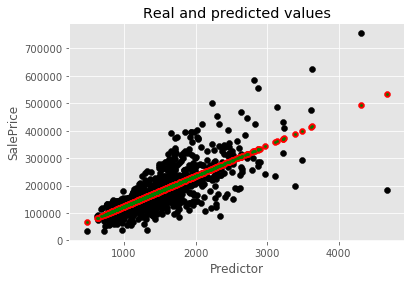

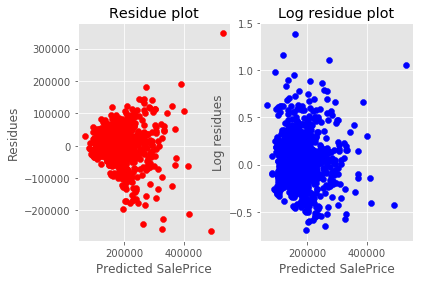

In [22]:
# create train/test data from the competition train data. 
X_train,X_test,Y_train,Y_test = train_test_split(df_train['GrLivArea'],df_train['SalePrice'],\
                                                  test_size=0.4, random_state=0)

# reshape all dataframes to dim(x,1) instead of (x,)
X_train,X_test,Y_train,Y_test = map(lambda x: x.values.reshape(len(x),1),\
                                    [X_train,X_test,Y_train,Y_test])

linreg=LinearRegression()

# fit the model to the train split of the training data
# view parameters
linreg.fit(X_train,Y_train)

Y_train_predicted = linreg.predict(X_train)

print("\n **************** Model parameters \n")

print("Intercept:",linreg.intercept_)

print("Coefficients:", linreg.coef_)

print("\n **************** Check own eval. metrics on the training set \n")

print("Residues:", linreg.residues_)

print("RMSE:", calc_rmse(linreg.residues_, len(X_train)))

print("RMSE by Hand:", calc_rmse_by_hand(Y_train_predicted,Y_train, X_train))

print('LOGRMSE by Hand:',calc_logrmse_by_hand(Y_train_predicted,Y_train, X_train))

print("R^2:", linreg.score(X_train,Y_train))

print("R^2 by hand:", calc_r_sq_by_hand(Y_train_predicted, Y_train))

print("Adjusted R^2:", calc_adj_r_sq_by_hand(Y_train_predicted, Y_train, X_train.shape[1]))

print("Avg deviation:", calc_avg_deviation(Y_train_predicted, Y_train))

print("Max deviation:", calc_max_deviation(Y_train_predicted, Y_train))

plot_real_and_predicted_values(X_train,Y_train,Y_train_predicted,linreg.intercept_,linreg.coef_)

plot_residues(Y_train_predicted,Y_train, X_train )



The self coded error / score measures yield the correct values. We will use them in the future.


Models and evalutions on the test data for:
Models with non-transformed and transformed SalePrice and their evaluations as well as an evaluation on the re-transformed log SalePrice data.


Model with SalePrice


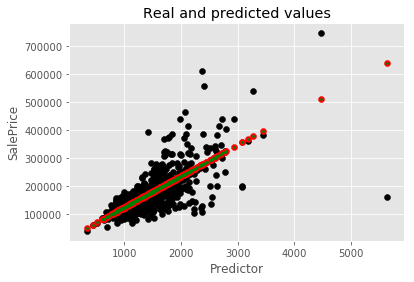

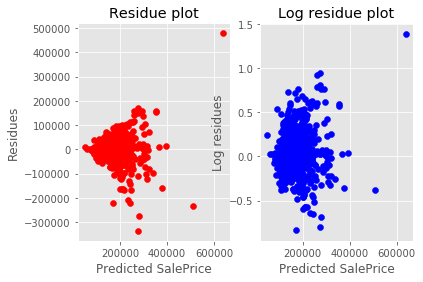

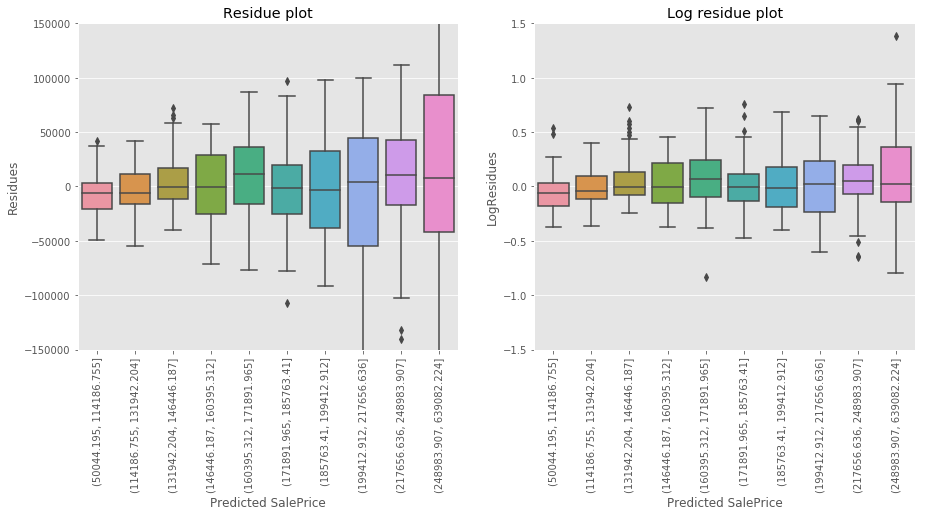

Model with log SalePrice


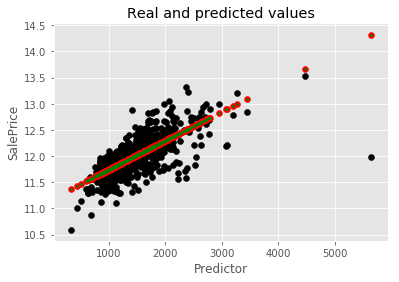

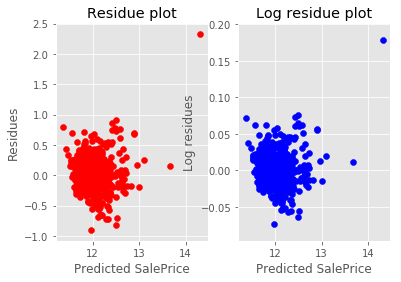

Model with log SalePrice after retransformation:


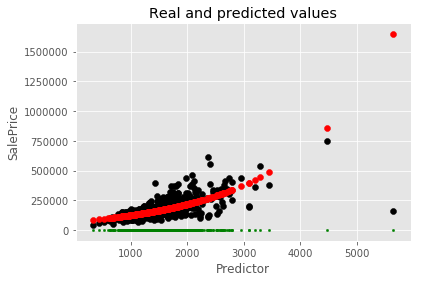

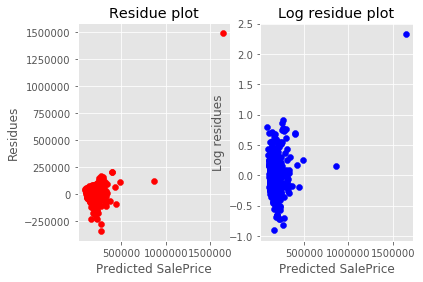

RMSE   Avg. dev.      Max dev.  LOGRMSE  \
Model      Data type                                                      
Univariate SalePrice     58071.29516   582.16500  479082.22402  0.27228   
           Log SalePrice     0.28586     0.00089       2.33121  0.02351   
           Retrafo       82781.73182 -4352.27084 1486468.23047  0.28586   

                              R^2  Adj. R^2  
Model      Data type                         
Univariate SalePrice      0.45868   0.45775  
           Log SalePrice  0.45889   0.45796  
           Retrafo       -0.10002  -0.10191

In [23]:
Y_test_predicted = linreg.predict(X_test)

model_results = pd.DataFrame(data = [[
                                    calc_rmse_by_hand(Y_test_predicted,Y_test, X_test),\
                                    calc_avg_deviation(Y_test_predicted, Y_test),\
                                    calc_max_deviation(Y_test_predicted, Y_test),\
                                    calc_logrmse_by_hand(Y_test_predicted,Y_test, X_test),\
                                    calc_r_sq_by_hand(Y_test_predicted, Y_test),\
                                    calc_adj_r_sq_by_hand(Y_test_predicted, Y_test,Y_train.shape[1])\
                                    ],\
                                    []], \
                    index = [['Univariate','Univariate'],\
                                      ['SalePrice', 'Log SalePrice']],\
                    columns = ['RMSE', 'Avg. dev.', 'Max dev.', 'LOGRMSE', 'R^2', 'Adj. R^2'])
model_results.index.names = ['Model', 'Data type']

print('\nModel with SalePrice')

# visualize y, y_hat and the draw regression line from the validation set
plot_real_and_predicted_values(X_test,Y_test,Y_test_predicted,linreg.intercept_,linreg.coef_)
# visualize residues and log residues vs. y_hat
plot_residues(Y_test_predicted,Y_test, X_test )

plot_residues_boxed(Y_test_predicted,Y_test, X_test )


X_train,X_test,Y_train,Y_test = train_test_split (df_train['GrLivArea'], \
                                df_train['SalePrice'].apply(lambda x:  np.log(x)), \
                                test_size=0.4, random_state=0
                                )

X_train,X_test,Y_train,Y_test = map(lambda x: x.values.reshape(len(x),1),[X_train,X_test,Y_train,Y_test])

linreg=LinearRegression()

linreg.fit(X_train,Y_train)

Y_test_predicted = linreg.predict(X_test)

model_results.loc[('Univariate','Log SalePrice'),:] = \
                   [
                    calc_rmse_by_hand(Y_test_predicted,Y_test, X_test),\
                    calc_avg_deviation(Y_test_predicted, Y_test),\
                    calc_max_deviation(Y_test_predicted, Y_test),\
                    calc_logrmse_by_hand(Y_test_predicted,Y_test, X_test),\
                    calc_r_sq_by_hand(Y_test_predicted, Y_test),\
                    calc_adj_r_sq_by_hand(Y_test_predicted, Y_test,Y_test.shape[1])\
                                    ]    

print('Model with log SalePrice')
    
plot_real_and_predicted_values(X_test,Y_test,Y_test_predicted,linreg.intercept_,linreg.coef_)

plot_residues(Y_test_predicted,Y_test, X_test )


Y_test = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test)

Y_test_predicted = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test_predicted)

model_results.loc[('Univariate','Retrafo'),:] = \
                      [
                    calc_rmse_by_hand(Y_test_predicted,Y_test, X_test),\
                    calc_avg_deviation(Y_test_predicted, Y_test),\
                    calc_max_deviation(Y_test_predicted, Y_test),\
                    calc_logrmse_by_hand(Y_test_predicted,Y_test, X_test),\
                    calc_r_sq_by_hand(Y_test_predicted, Y_test),\
                    calc_adj_r_sq_by_hand(Y_test_predicted, Y_test,Y_test.shape[1])\
                                    ]


print('Model with log SalePrice after retransformation:')

plot_real_and_predicted_values(X_test,Y_test,Y_test_predicted,linreg.intercept_,linreg.coef_)

plot_residues(Y_test_predicted,Y_test, X_test )

display(model_results)


To notice, the low avgerage deviation on the training set increased on the validation set. The model overestimates the SalePrice systematically.

The log transformation leads to a worse model. As the R^2 values are negative, i assume its due to the obvious outliers.

In [24]:
# take the real test data for submission! 1459 rows!
# index of output file must be 1461 to 2919
Y_test_predicted = linreg.predict(df_test['GrLivArea'].values.reshape(len(df_test),1))

makeOutputFile(pd.DataFrame(data = Y_test_predicted, columns=['SalePrice'], index = range(1461,2920,1)), \
                'SalePrice', \
                 1
               )


 **************** Output written to: 'My_submission_1.csv' 



# 3 Removing outliers

In [25]:
display(merged_data.sort_values('GrLivArea')[['SalePrice','GrLivArea']].tail(7))

display(merged_data.sort_values('GrLivArea')[['GrLivArea']].tail(7))

,SalePrice,GrLivArea
Id,,
2823,nan,3672
2189,nan,3820
692,755000.00000,4316
1183,745000.00000,4476
524,184750.00000,4676
2550,nan,5095
1299,160000.00000,5642


,GrLivArea
Id,
2823,3672
2189,3820
692,4316
1183,4476
524,4676
2550,5095
1299,5642


According to the publisher of the dataset, the houses with an area above 4000 sq ft maybe show irregular behavior regarding their sale price. Indeed the houses with such area values can be detected as the outliers in the scatter plots above.

The house with thd index "Id = 2550" can not be removed, as it belongs to the test data used for the contest predictions.

In [26]:
merged_data = merged_data.drop([692,1183,524,1299])# drops exact indices

#df_train_copy = df_train_copy.reset_index(drop = True) # close gaps in index

#df_train_copy.index = df_train_copy.index+1 # start like the original index

display(merged_data.head(2))

display(merged_data.tail(2))


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,Simp_Neighborhood,Log_SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,856,854,0,NA,3,1Fam,TA,No,706.00000,0.00000,GLQ,Unf,1.00000,0.00000,Gd,150.00000,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NA,NA,0,PConc,2,Typ,548.00000,2.00000,TA,RFn,TA,Attchd,2003.00000,1710,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,8450,Inside,65.00000,Reg,0,60,RL,196.00000,BrkFace,NA,0,2,CollgCr,61,5,7,Y,0,NA,CompShg,Gable,Normal,208500.00000,WD,0,Pave,8,856.00000,AllPub,0,2003,2003,2008,4,12.24769
2,1262,0,0,NA,3,1Fam,TA,Gd,978.00000,0.00000,ALQ,Unf,0.00000,1.00000,Gd,284.00000,Y,Feedr,Norm,SBrkr,0,TA,TA,MetalSd,MetalSd,NA,TA,1,CBlock,2,Typ,460.00000,2.00000,TA,RFn,TA,Attchd,1976.00000,1262,0,GasA,Ex,1Story,1,TA,Lvl,Gtl,9600,FR2,80.00000,Reg,0,20,RL,0.00000,None,NA,0,5,Veenker,0,8,6,Y,0,NA,CompShg,Gable,Normal,181500.00000,WD,0,Pave,6,1262.00000,AllPub,298,1976,1976,2007,1,12.10901


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,Simp_Neighborhood,Log_SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2918,970,0,0,NA,3,1Fam,TA,Av,337.00000,0.00000,GLQ,Unf,0.00000,1.00000,Gd,575.00000,Y,Norm,Norm,SBrkr,0,TA,TA,HdBoard,Wd Shng,MnPrv,NA,0,PConc,1,Typ,0.00000,0.00000,NA,NA,NA,NA,nan,970,0,GasA,TA,SFoyer,1,TA,Lvl,Gtl,10441,Inside,62.00000,Reg,0,85,RL,0.00000,None,Shed,700,7,Mitchel,32,5,5,Y,0,NA,CompShg,Gable,Normal,nan,WD,0,Pave,6,912.00000,AllPub,80,1992,1992,2006,2,nan
2919,996,1004,0,NA,3,1Fam,TA,Av,758.00000,0.00000,LwQ,Unf,0.00000,0.00000,Gd,238.00000,Y,Norm,Norm,SBrkr,0,TA,TA,HdBoard,HdBoard,NA,TA,1,PConc,2,Typ,650.00000,3.00000,TA,Fin,TA,Attchd,1993.00000,2000,1,GasA,Ex,2Story,1,TA,Lvl,Mod,9627,Inside,74.00000,Reg,0,60,RL,94.00000,BrkFace,NA,0,11,Mitchel,48,5,7,Y,0,NA,CompShg,Gable,Normal,nan,WD,0,Pave,9,996.00000,AllPub,190,1993,1994,2006,2,nan


In [27]:
merged_data.SalePrice.max()

625000.0

# 3.1 Re-model with GrLivArea with dropped outliers

RMSE   Avg. dev.      Max dev.  LOGRMSE  \
Model            Data type                                                      
Univariate       SalePrice     58071.29516   582.16500  479082.22402  0.27228   
                 Log SalePrice     0.28586     0.00089       2.33121  0.02351   
                 Retrafo       82781.73182 -4352.27084 1486468.23047  0.28586   
Outliers removed Log SalePrice     0.28586     0.00089       2.33121  0.02351   
                 Retrafo.      82781.73182 -4352.27084 1486468.23047  0.28586   

                                    R^2  Adj. R^2  
Model            Data type                         
Univariate       SalePrice      0.45868   0.45775  
                 Log SalePrice  0.45889   0.45796  
                 Retrafo       -0.10002  -0.10191  
Outliers removed Log SalePrice  0.45889   0.45796  
                 Retrafo.      -0.10002  -0.10191

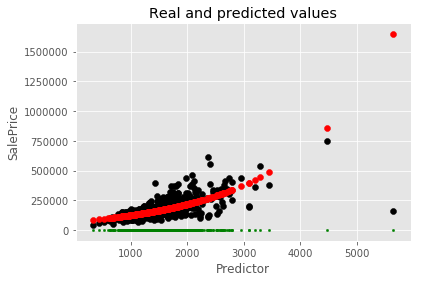

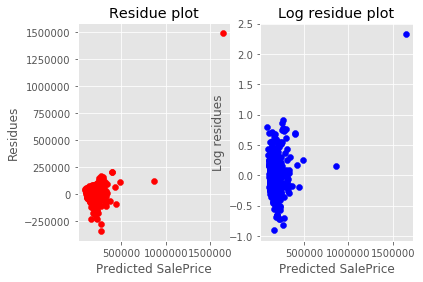

In [28]:
del(df_train, df_test, X_train,Y_train, X_test, Y_test)

df_train = merged_data.loc[merged_data.index <= 1460].copy()

df_test = merged_data.loc[merged_data.index > 1460].copy()

df_train = df_train_copy.reset_index(drop = True) # close gaps in index

df_train.index = df_train_copy.index+1 # start like the original index

X_train,X_test,Y_train,Y_test = train_test_split(df_train['GrLivArea'], \
                                df_train['SalePrice'].apply(lambda x:  np.log(x)), \
                                test_size=0.4, random_state=0
                                )

X_train,X_test,Y_train,Y_test = map(lambda x: x.values.reshape(len(x),1),\
                                    [X_train,X_test,Y_train,Y_test])

linreg=LinearRegression()

linreg.fit(X_train,Y_train)

Y_test_predicted = linreg.predict(X_test)

model_results.loc[('Outliers removed','Log SalePrice'),:] = \
                      [
                    calc_rmse_by_hand(Y_test_predicted,Y_test, X_test),\
                    calc_avg_deviation(Y_test_predicted, Y_test),\
                    calc_max_deviation(Y_test_predicted, Y_test),\
                    calc_logrmse_by_hand(Y_test_predicted,Y_test, X_test),\
                    calc_r_sq_by_hand(Y_test_predicted, Y_test),\
                    calc_adj_r_sq_by_hand(Y_test_predicted, Y_test,Y_test.shape[1])\
                                    ]


Y_test = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test)

Y_test_predicted = np.apply_along_axis(lambda x: np.exp(x), 1,Y_test_predicted)

model_results.loc[('Outliers removed','Retrafo.'),:] = \
                      [
                    calc_rmse_by_hand(Y_test_predicted,Y_test, X_test),\
                    calc_avg_deviation(Y_test_predicted, Y_test),\
                    calc_max_deviation(Y_test_predicted, Y_test),\
                    calc_logrmse_by_hand(Y_test_predicted,Y_test, X_test),\
                    calc_r_sq_by_hand(Y_test_predicted, Y_test),\
                    calc_adj_r_sq_by_hand(Y_test_predicted, Y_test,Y_test.shape[1])\
                                    ]

display(model_results)    
    
plot_real_and_predicted_values(X_test,Y_test,Y_test_predicted,linreg.intercept_,linreg.coef_)
# visualize residues and log residues vs. the predicted SalePrice
plot_residues(Y_test_predicted,Y_test, X_test )

First of all, the removing of the outliers lead to positive R^2 values as assumed.

It is interesting that removing outliers and applying the log trafo to the target variable, does not lead to improved scores or reduced errors in any case.
Especially the competition metric LOGRMSE is higher than for the model with SalePrice as it is.

# 4. Modeling with categorical varriables and dummy encoding

RMSE   Avg. dev.      Max dev.  LOGRMSE  \
Model            Data type                                                      
Univariate       SalePrice     58071.29516   582.16500  479082.22402  0.27228   
                 Log SalePrice     0.28586     0.00089       2.33121  0.02351   
                 Retrafo       82781.73182 -4352.27084 1486468.23047  0.28586   
Outliers removed Log SalePrice     0.28586     0.00089       2.33121  0.02351   
                 Retrafo.      82781.73182 -4352.27084 1486468.23047  0.28586   
Added cat. feat. No dummy          0.16720    -0.00016       0.68773  0.01408   
                 Dummy             0.16781     0.00174       0.65878  0.01409   

                                    R^2  Adj. R^2  
Model            Data type                         
Univariate       SalePrice      0.45868   0.45775  
                 Log SalePrice  0.45889   0.45796  
                 Retrafo       -0.10002  -0.10191  
Outliers removed Log SalePrice  0.45889   0.45796  
                 Retrafo.      -0.10002  -0.10191  
Added cat. feat. No dummy       0.82125   0.82084  
                 Dummy          0.81995   0.81953

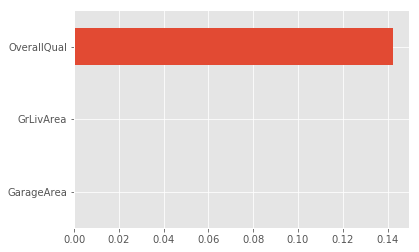

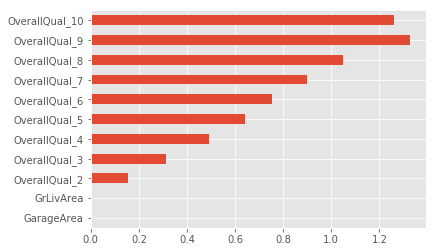

In [29]:
del(df_train, df_test, X_train,Y_train, X_test, Y_test)

df_train = merged_data.loc[merged_data.index <= 1460].copy()

df_test = merged_data.loc[merged_data.index > 1460].copy()

X_train,X_test,Y_train,Y_test = train_test_split(df_train[['GarageArea','GrLivArea','OverallQual']], \
                                df_train['SalePrice'].apply(lambda x:  np.log(x)), \
                                test_size=0.3, random_state=0
                              )

Y_train,Y_test = map(lambda x: x.values.reshape(len(x),1),[Y_train,Y_test])

linreg=LinearRegression()

linreg.fit(X_train,Y_train)

Y_test_predicted = linreg.predict(X_test)

model_results.loc[('Added cat. feat.','No dummy'),:] = \
                      [
                    calc_rmse_by_hand(Y_test_predicted,Y_test, X_test),\
                    calc_avg_deviation(Y_test_predicted, Y_test),\
                    calc_max_deviation(Y_test_predicted, Y_test),\
                    calc_logrmse_by_hand(Y_test_predicted,Y_test, X_test),\
                    calc_r_sq_by_hand(Y_test_predicted, Y_test),\
                    calc_adj_r_sq_by_hand(Y_test_predicted, Y_test,Y_test.shape[1])\
                    ]
coef = pd.Series(linreg.coef_[0], index = X_train.columns).copy()
#coef.plot(kind = "barh")
#plt.title("Coefficients in the Linear Model")
#plt.show()
    
merged_data_copy = merged_data[['GarageArea','GrLivArea','OverallQual','SalePrice']].copy()

dummies = pd.get_dummies(merged_data_copy.OverallQual, prefix='OverallQual')

merged_data_copy = pd.concat([merged_data_copy, dummies], axis = 1)

merged_data_copy = merged_data_copy.drop(['OverallQual_1','OverallQual'], axis = 1)

df_train = merged_data_copy.loc[merged_data.index <= 1460].copy()

df_test = merged_data_copy.loc[merged_data.index > 1460].copy()

X_train,X_test,Y_train,Y_test = train_test_split(df_train.loc[:,df_train.columns != 'SalePrice'], \
                                df_train['SalePrice'].apply(lambda x:  np.log(x)), \
                                test_size=0.3, random_state=0
                              )
Y_train,Y_test = map(lambda x: x.values.reshape(len(x),1),[Y_train,Y_test])

linreg=LinearRegression()

linreg.fit(X_train,Y_train)

Y_test_predicted = linreg.predict(X_test)

model_results.loc[('Added cat. feat.','Dummy'),:] = \
                      [
                    calc_rmse_by_hand(Y_test_predicted,Y_test, X_test),\
                    calc_avg_deviation(Y_test_predicted, Y_test),\
                    calc_max_deviation(Y_test_predicted, Y_test),\
                    calc_logrmse_by_hand(Y_test_predicted,Y_test, X_test),\
                    calc_r_sq_by_hand(Y_test_predicted, Y_test),\
                    calc_adj_r_sq_by_hand(Y_test_predicted, Y_test,Y_test.shape[1])\
                    ]

display(model_results)

coef2 = pd.Series(linreg.coef_[0], index = df_train.loc[:,df_train.columns != 'SalePrice'].columns)



coef.plot.barh()

plt.show()

coef2.plot.barh()

plt.show()

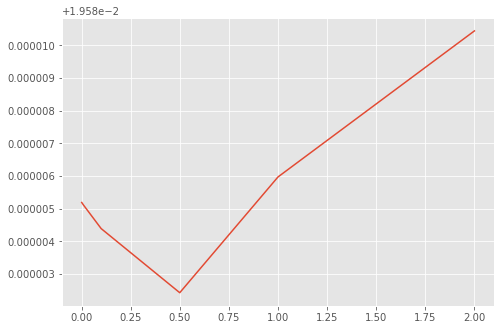

In [30]:
rootlogrmse = make_scorer(calc_logrmse_by_hand2,greater_is_better = True)  

splitting_strategy = KFold(n_splits=3, shuffle=False)

alphas_list = [.001,0.01,0.1,0.5,1, 2]


lasso_results = [cross_val_score(Lasso(alpha = alpha, max_iter=400000, tol=0.01), df_train.loc[:,df_train.columns != 'SalePrice'],\
                    df_train['SalePrice'], cv=splitting_strategy, scoring=rootlogrmse).mean() for alpha in alphas_list]

fig = plt.figure()

ax = fig.add_axes([0,0,1,1,])

ax.plot(alphas_list, lasso_results)
plt.show()

Accuracy of own rmse func: 0.0196 (+/- 0.0001)


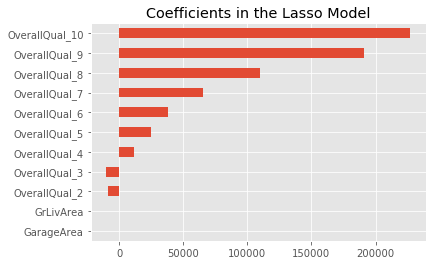

In [31]:
lasso = Lasso(alpha=0.05, max_iter = 40000)

lasso.fit( df_train.loc[:,df_train.columns != 'SalePrice'],\
                    df_train['SalePrice'])

# is generated after the fit!

w = cross_val_score(lasso, df_train.loc[:,df_train.columns != 'SalePrice'],\
                    df_train['SalePrice'], cv=splitting_strategy, scoring=rootlogrmse)

print("Accuracy of own rmse func: %0.4f (+/- %0.4f)" % (w.mean(), w.std() * 2))

coef = pd.Series(lasso.coef_, index = df_train.loc[:,df_train.columns != 'SalePrice'].columns)

coef.plot(kind = "barh")

plt.title("Coefficients in the Lasso Model")

plt.show()

In [32]:
#
#!jupyter nbconvert --to script the_main_file_v2.ipynb

